# 네이버 영화 리뷰 감성 분류하기(Naver Movie Review Sentiment Analysis)

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [20]:
# 텍스트 파일 받아오기 (urlretrieve -> 바로 디렉토리에 저장됨)
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f8987653130>)

In [21]:
train = pd.read_table('ratings_train.txt')
train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [22]:
test = pd.read_table('ratings_test.txt')

## 전처리

In [23]:
# 결측치 확인
train.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [24]:
test.isnull().sum()

id          0
document    3
label       0
dtype: int64

In [25]:
# 결측치 있는 행 drop

train = train.dropna(axis=0)
test = test.dropna(axis=0)

In [26]:
train.shape, test.shape

((149995, 3), (49997, 3))

In [27]:
# 중복 확인
train.duplicated(['document']).sum(),
test.duplicated(['document']).sum()

840

In [28]:
train.drop_duplicates(['document'], inplace=True)
test.drop_duplicates(['document'], inplace=True)

/Users/zhenxi/opt/anaconda3/envs/fourth_project/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [29]:
train.shape, test.shape

((146182, 3), (49157, 3))

In [30]:
# train set의 label 값 비율 확인
train.label.value_counts()

0    73342
1    72840
Name: label, dtype: int64

In [31]:
# 특수문자 제거 (한글, 띄어쓰기만 가능)
regex = '[^가-힣\s]'
train['document'] = train['document'].str.replace(regex, "")
train['document']

/var/folders/r6/l64l2rzj64ddspvkmw8zr_hh0000gn/T/ipykernel_17174/3911727727.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train['document'] = train['document'].str.replace(regex, "")
/var/folders/r6/l64l2rzj64ddspvkmw8zr_hh0000gn/T/ipykernel_17174/3911727727.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['document'] = train['document'].str.replace(regex, "")


0                                         아 더빙 진짜 짜증나네요 목소리
1                                흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                                 교도소 이야기구먼 솔직히 재미는 없다평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...
                                ...                        
149995                                      인간이 문제지 소는 뭔죄인가
149996                                           평점이 너무 낮아서
149997                        이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다
149998                           청춘 영화의 최고봉방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 146182, dtype: object

In [32]:
test['document'] = test['document'].str.replace(regex, "")

/var/folders/r6/l64l2rzj64ddspvkmw8zr_hh0000gn/T/ipykernel_17174/1063151508.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  test['document'] = test['document'].str.replace(regex, "")


In [33]:
# 불용어 설정 (파일 출처 : https://bab2min.tistory.com/544)
stop_words = pd.read_table('KR_stopwords.txt', header=None)
stop_words = stop_words[0]
stop_words = stop_words.values
stop_words = stop_words.tolist()

In [34]:
# 형태소 분석 (토큰화)
okt = Okt()

# 토큰화를 위한 함수 정의
def tokenize(column):
    tokenized_column = []
    for text in column :
        text = okt.normalize(text)
        tokens = okt.morphs(text)
        tokens = [word for word in tokens if word not in stop_words]
        tokenized_column.append(tokens)
    return tokenized_column


In [35]:
train['document'] = tokenize(train['document'])
test['document'] = tokenize(test['document'])

/var/folders/r6/l64l2rzj64ddspvkmw8zr_hh0000gn/T/ipykernel_17174/1933683591.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['document'] = tokenize(train['document'])


In [36]:
# 참고) 아직 test는 tokenize함수를 적용하지 않음
# train_test_split

X_train = train['document']
y_train = train['label']
X_test = test['document']
y_test = test['label']

In [37]:
# 빈도가 적은 단어 삭제 
X_train.head()

0                              [아, 더빙, 진짜, 짜증나네요, 목소리]
1        [흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍지, 않구나]
2                     [너, 무재, 밓었, 다그, 래서, 보는것을, 추천, 다]
3               [교도소, 이야기, 구먼, 솔직히, 재미, 는, 없다, 평점, 조정]
4    [사이, 몬페, 의, 익살스런, 연기, 돋보였던, 영화, 스파이더맨, 에서, 늙어,...
Name: document, dtype: object

In [38]:
all_words_list = sum(X_train, [])

In [39]:
vocab_prequency = Counter(all_words_list)
vocab_prequency["노잼"] # "노잼"이라는 단어가 몇개나 있는지 return해줍니다.

724

In [40]:
# 빈도가 적은 단어 삭제 -> 단어가 2개 이하로 나온 경우 해당 단어 삭제
# prequent_row : 3개 이상의 단어부터만 수록한 행

prequent_X_train = []

for row in X_train :
    prequent_row = [word for word in row if vocab_prequency[word] > 2]
    prequent_X_train.append(prequent_row)

# prequent_X_train을 다시 X_train에 넣어줍니다.
X_train = prequent_X_train

In [41]:
X_train[:3]

[['아', '더빙', '진짜', '짜증나네요', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍지', '않구나'],
 ['너', '무재', '다그', '래서', '보는것을', '추천', '다']]

In [42]:
# 정수 인코딩

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [43]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [44]:
# 정수화가 잘 되었는지 확인
X_train[:3]


[[37, 370, 13, 6266, 565],
 [837, 371, 30, 511, 1, 150, 1448, 18, 868, 6090, 25461],
 [344, 25462, 2506, 7177, 11837, 157, 10]]

In [45]:
X_test[:3]

[[744], [], [40, 119, 19, 6, 4541, 1334, 877, 789, 7, 691, 3315]]

In [46]:
# 리뷰 길이 분포 확인(padding작업을 위해)
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 63
리뷰의 평균 길이 : 10.501648629790262


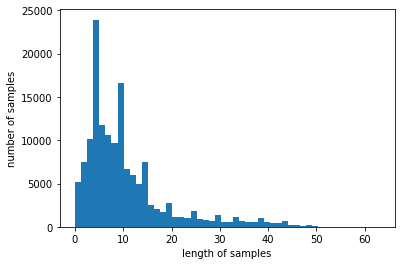

In [47]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [50]:
# 위의 히스토그램을 바탕으로 padding의 길이를 정해줍니다.
# 25~30 정도가 적당해 보이네요!

max_len = 30
X_train = pad_sequences(X_train, maxlen = max_len)

In [49]:
X_test = pad_sequences(X_test, maxlen = max_len)

In [51]:
# 마지막으로 길이를 확인해줍니다.
len(X_train), len(y_train)

(146182, 146182)

In [52]:
len(X_test), len(y_test)

(49157, 49157)

## 모델링

In [60]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [58]:
vocab_size = len(X_train)+1

In [61]:
embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

2021-11-10 15:03:05.311981: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [66]:
callback_es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callback_mc = ModelCheckpoint('{epoch:02d}-{val_acc:.5f}.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# 체크포인트로 epoch에서 가장 성능이 괜찮은 모델을 저장해준다. 
# mode = max -> monitor가 val_acc이기 때문에 클수록(max)좋다!

In [67]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.fit(X_train, y_train, epochs=50, callbacks=[callback_es, callback_mc], batch_size=64, validation_split=0.2)

Epoch 1/50
1828/1828 [==============================] - ETA: 0s - loss: 0.3483 - acc: 0.8452
Epoch 00001: val_acc improved from -inf to 0.84780, saving model to 01-0.84780.h5
1828/1828 [==============================] - 428s 233ms/step - loss: 0.3483 - acc: 0.8452 - val_loss: 0.3421 - val_acc: 0.8478
Epoch 2/50
1828/1828 [==============================] - ETA: 0s - loss: 0.2696 - acc: 0.8839
Epoch 00002: val_acc improved from 0.84780 to 0.84804, saving model to 02-0.84804.h5
1828/1828 [==============================] - 409s 223ms/step - loss: 0.2696 - acc: 0.8839 - val_loss: 0.3536 - val_acc: 0.8480
Epoch 3/50
1828/1828 [==============================] - ETA: 0s - loss: 0.2141 - acc: 0.9088
Epoch 00003: val_acc did not improve from 0.84804
1828/1828 [==============================] - 399s 219ms/step - loss: 0.2141 - acc: 0.9088 - val_loss: 0.3896 - val_acc: 0.8441
Epoch 4/50
1828/1828 [==============================] - ETA: 0s - loss: 0.1670 - acc: 0.9299
Epoch 00004: val_acc did not i

In [68]:
# 02-0.84804.h5 이후로 improve 되지 않았음

loaded_model = load_model('02-0.84804.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1537/1537 [==============================] - 9s 6ms/step - loss: 0.3632 - acc: 0.8438

 테스트 정확도: 0.8438


## 직접 샘플을 만들어 예측해보자

In [118]:
# 전처리 + 예측해주는 함수

def my_predict(my_sentence):
    my_sentence = my_sentence.replace(regex, "")
    my_sentence = okt.normalize(my_sentence)
    my_sentence = okt.morphs(my_sentence)
    my_sentence = [word for word in my_sentence if word not in stop_words]
    my_sentence = tokenizer.texts_to_sequences([my_sentence])
    my_sentence = pad_sequences(my_sentence, maxlen = max_len)
    result = float(loaded_model.predict(my_sentence))
    if result > 0.5 :
        return print('{:.2f}% 긍정적인 평가입니다 ^__^'.format(result*100))
    else :
        return print('{:.2f}% 부정적인 평가입니다 ㅠ__ㅠ'.format((1-result)*100))

In [123]:
my_predict('연기만 괜찮고 나머지는 다 별로인 영화')


95.91% 부정적인 평가입니다 ㅠ__ㅠ


In [124]:
my_predict('이걸 아직도 안본 사람이 있음?')

70.21% 긍정적인 평가입니다 ^__^


In [125]:
my_predict('결말이 아쉬웠는데 그럭저럭 볼만함')

50.08% 긍정적인 평가입니다 ^__^


In [126]:
my_predict('추석에 가족들이랑 보기 좋은 영화!')

79.35% 긍정적인 평가입니다 ^__^


In [127]:
my_predict('돈버림')

97.94% 부정적인 평가입니다 ㅠ__ㅠ


In [132]:
my_predict('돈 쥐어주면서 보라고 해도 안볼듯ㅋㅋㅋㅋ')

84.87% 부정적인 평가입니다 ㅠ__ㅠ


In [131]:
my_predict('믿고보는 봉준호 영화')

97.20% 긍정적인 평가입니다 ^__^


In [134]:
my_predict('ㄹㅇ 띵작임 안보면 개손해')

65.36% 부정적인 평가입니다 ㅠ__ㅠ
